In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
mta_data = pd.read_csv('data/MTA_Bridges___Tunnels_Hourly_Traffic_Rates__Beginning_2010_20241012.csv', thousands=',',
                       dtype={
                        'Plaza ID': int,
                        'Hour': int,
                        'Direction': str,
                        '# Vehicles - E-ZPass': int,
                        '# Vehicles - VToll': int
                       }, parse_dates=['Date'])
mta_data['Total Vehicles'] = mta_data['# Vehicles - E-ZPass'] + mta_data['# Vehicles - VToll']

plaza_ids = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
mta_data = mta_data[mta_data['Plaza ID'].isin(plaza_ids)]

In [3]:
mta_data['Date'].dt.isocalendar().week

0          40
1          40
2          40
3          40
4          40
           ..
1052366    35
1052367    35
1052368    35
1052369    35
1052370    35
Name: week, Length: 1050355, dtype: UInt32

In [4]:
mta_data

,Plaza ID,Date,Hour,Direction,# Vehicles - E-ZPass,# Vehicles - VToll,Total Vehicles
0,21,2024-10-05,0,I,2514,597,3111
1,21,2024-10-05,1,I,1607,414,2021
2,21,2024-10-05,2,I,1176,332,1508
3,21,2024-10-05,3,I,1223,324,1547
4,21,2024-10-05,4,I,1778,453,2231
...,...,...,...,...,...,...,...
1052366,30,2017-09-03,19,O,4176,529,4705
1052367,30,2017-09-03,20,O,4133,547,4680
1052368,30,2017-09-03,21,O,3703,506,4209
1052369,30,2017-09-03,22,O,3364,498,3862


In [5]:
pd.date_range(start="2017-09-03", end="2024-10-05").difference(mta_data['Date'])

DatetimeIndex(['2017-09-24', '2017-09-25', '2017-09-26', '2017-09-27',
               '2017-09-28', '2017-09-29', '2017-09-30', '2017-10-01',
               '2017-10-02', '2017-10-03', '2017-10-04', '2017-10-05',
               '2017-10-06', '2017-10-07', '2017-10-08', '2017-10-09',
               '2017-10-10', '2017-10-11', '2017-10-12', '2017-10-13',
               '2017-10-14', '2017-10-15', '2017-10-16', '2017-10-17',
               '2017-10-18', '2017-10-19', '2017-10-20', '2017-10-21',
               '2017-10-29', '2017-10-30', '2017-10-31', '2017-11-01',
               '2017-11-02', '2017-11-03', '2017-11-04', '2017-11-05',
               '2017-11-06', '2017-11-07', '2017-11-08', '2017-11-09',
               '2017-11-10', '2017-11-11', '2017-12-10', '2017-12-11',
               '2017-12-12', '2017-12-13', '2017-12-14', '2017-12-15',
               '2017-12-16', '2018-07-01', '2018-08-05', '2018-08-06',
               '2018-08-07', '2018-08-08', '2018-08-09', '2018-08-10',
      

There are no missing dates in the dataset. There are missing hours, so we will need to deal with that.

In [6]:
groupby_date = mta_data.groupby('Date').count()

In [311]:
# since we are missing hours in some parts, using a dictionary would be the safest option
data_dict = dict()
# keys are ((plaza_id, day of week), (week number, year))
for date in tqdm(pd.date_range(start="2017-09-03", end="2024-10-05")):
    pydatetime = date.to_pydatetime()
    week_number = pydatetime.isocalendar().week
    year = pydatetime.isocalendar().year
    weekday = pydatetime.isocalendar().weekday
    
    data_slice = mta_data[mta_data['Date'] == date]
    
    for plaza_id in plaza_ids:
        if data_slice.empty:
            data_dict[((plaza_id, weekday), (week_number, year))] = None
            continue
        key = ((plaza_id, weekday), (week_number, year))
        data = data_slice[data_slice['Plaza ID'] == plaza_id][['Hour', 'Total Vehicles']]
        data = data[data_slice['Direction'] == 'I']
        data.set_index('Hour', inplace=True)
        data_dict[key] = data
        
normalized_dict = dict()
for key, value in data_dict.items():
    if value is None:
        normalized_dict[key] = None
        continue
    if len(value) == 0:
        normalized_dict[key] = None
        continue
    normalized_dict[key] = value / value.sum()

100%|██████████| 2590/2590 [00:13<00:00, 191.82it/s]


In [312]:
count = 0
for v in data_dict.values():
    if v is None:
        count += 1
        continue
    if len(v) == 0:
        count += 1
        continue
print(f'Mising Value: {count}, Percent Missing: {count / len(data_dict) * 100}%')

Mising Value: 4616, Percent Missing: 17.822393822393824%


`data_dict` has keys in the form ((plaza id, weekday), (week number, year)). From this, we can build a matrix where the first pairs along the rows and the second pairs along the columns.

We need to test 3 different setups to see which is the best:
1. (normalize, Wasserstein)
2. (normalize, Euclidean)
3. (no normalization, Euclidean)

We cannot use Wasserstein with no normalization because then it is not a distribution.

The matrix size is 70 x (number of weeks * number of years). The 70 comes from (number of days in week * 10 plaza_ids)

In [60]:
from scipy.integrate import quad
from functools import partial
from numpy import quantile

import warnings
warnings.filterwarnings("ignore")

def wasserstein2(inv_cdf1, inv_cdf2):
    """
    Compute the squared 2-Wasserstein metric.
    """
    # Combine the inner part of the integral into one function
    # Estimate integral via quadrature
    y, _ = quad(lambda x : np.power((inv_cdf1(x) - inv_cdf2(x)), 2), 0, 1)
    return y

def wasserstein2_mc(ppf1, ppf2):
    N = 10000
    u = np.random.uniform(0,1,N)
    return np.sum(np.power(ppf1(u) - ppf2(u), 2)) / N

def discrete_quantile(values, cdf, q):
    # Find the smallest value where the CDF is greater than or equal to the quantile q
    quantile_value = values[np.searchsorted(cdf, q)]
    
    return quantile_value

In [313]:
ppf_dict = dict()
for key, value in data_dict.items():
    if value is None:
        ppf_dict[key] = None
        continue
    if len(value) == 0:
        ppf_dict[key] = None
        continue
    value = value / value.sum()
    ppf = partial(discrete_quantile, value.index.to_numpy(), value.cumsum().values.flatten())
    ppf_dict[key] = ppf

In [318]:
ppf_dict.keys()

dict_keys([((21, 7), (35, 2017)), ((22, 7), (35, 2017)), ((23, 7), (35, 2017)), ((24, 7), (35, 2017)), ((25, 7), (35, 2017)), ((26, 7), (35, 2017)), ((27, 7), (35, 2017)), ((28, 7), (35, 2017)), ((29, 7), (35, 2017)), ((30, 7), (35, 2017)), ((21, 1), (36, 2017)), ((22, 1), (36, 2017)), ((23, 1), (36, 2017)), ((24, 1), (36, 2017)), ((25, 1), (36, 2017)), ((26, 1), (36, 2017)), ((27, 1), (36, 2017)), ((28, 1), (36, 2017)), ((29, 1), (36, 2017)), ((30, 1), (36, 2017)), ((21, 2), (36, 2017)), ((22, 2), (36, 2017)), ((23, 2), (36, 2017)), ((24, 2), (36, 2017)), ((25, 2), (36, 2017)), ((26, 2), (36, 2017)), ((27, 2), (36, 2017)), ((28, 2), (36, 2017)), ((29, 2), (36, 2017)), ((30, 2), (36, 2017)), ((21, 3), (36, 2017)), ((22, 3), (36, 2017)), ((23, 3), (36, 2017)), ((24, 3), (36, 2017)), ((25, 3), (36, 2017)), ((26, 3), (36, 2017)), ((27, 3), (36, 2017)), ((28, 3), (36, 2017)), ((29, 3), (36, 2017)), ((30, 3), (36, 2017)), ((21, 4), (36, 2017)), ((22, 4), (36, 2017)), ((23, 4), (36, 2017)), 

In [321]:
ppf_dict[((24, 2), (36, 2017))] is None

False

In [322]:
def get_wasserstein_dists(key, ppf_dict):
    dists = dict()
    (plaza_id, weekday), (week_number, year) = key
    # (plaza_id, weekday) is the row
    
    for key2, value2 in tqdm(ppf_dict.items()):
        if value2 is None:
            continue
        (plaza_id2, weekday2), (week_number2, year2) = key2 # unpack key2
        if week_number == week_number2 and year == year2: # if in the same column
            continue
        key_row1 = ((plaza_id, weekday), (week_number2, year2))
        if ppf_dict.get(key_row1) is not None:
            # if the list is not initialized, initialize it
            if dists.get((plaza_id2, weekday2)) is None:
                dists[(plaza_id2, weekday2)] = list()
            value1 = ppf_dict[key_row1]
            dists[(plaza_id2, weekday2)].append(wasserstein2_mc(value1, value2))
    return dists

key = ((24, 2), (36, 2017))
dists = get_wasserstein_dists(key, ppf_dict)

100%|██████████| 25900/25900 [00:12<00:00, 2144.16it/s]


100%|██████████| 100/100 [00:04<00:00, 24.08trial/s, best loss: 0.03740073075440035]
Distance Threshold: 0.4656617897598935
Number of neighbors (including self): 2


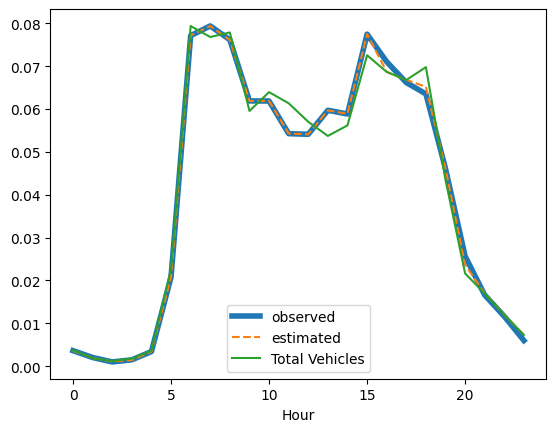

In [386]:
def get_barycenter(key, ppf_dict, neighbors):
    (_, _), (week_number, year) = key
    neighbor_ppfs = []
    for neighbor_key in neighbors:
        plaza_id2, weekday2 = neighbor_key
        if ppf_dict.get(((plaza_id2, weekday2), (week_number, year))) is not None:
            neighbor_ppfs.append(ppf_dict[((plaza_id2, weekday2), (week_number, year))])
    return lambda x: np.mean([ppf(x) for ppf in neighbor_ppfs])

def get_neighbors(key, data_dict, dists, dist_threshold):
    neighbors = []
    for key2, value in dists.items():
        if key2 == key[0]:
            continue
        if data_dict.get((key2, key[1])) is None:
            continue
        if len(data_dict.get((key2, key[1]))) == 0:
            continue
        if np.mean(value) < dist_threshold:
            neighbors.append(key2)
    return neighbors

def get_estimate_discrete_dist(key, ppf_dict, dists, dist_threshold):
    neighbors = get_neighbors(key, data_dict, dists, dist_threshold)
    if ppf_dict.get(key) is not None:
        neighbors.append(key[0])
    estimate_ppf = get_barycenter(key, ppf_dict, neighbors)
    x = np.linspace(0, 0.999999, 10000)
    y = [estimate_ppf(i) for i in x]

    barycenter_cumsum = np.interp(list(range(24)), y, x)
    return [barycenter_cumsum[0]] + np.diff(barycenter_cumsum).tolist()

from hyperopt import hp, tpe, fmin

def evaluate_dist_threshold(key, ppf_dict, dists, dist_threshold):
    neighbors = get_neighbors(key, data_dict, dists, dist_threshold)
    if len(neighbors) == 0: # if no neighbors, return high number
        return 100
    observed_ppf = ppf_dict[key] # observed ppf
    est_ppf = get_barycenter(key, ppf_dict, neighbors) # estimated ppf
    return wasserstein2(observed_ppf, est_ppf) # return wasserstein distance

def optimize_dist_threshold(key, ppf_dict, dists):
    def obj(dist_threshold):
        return evaluate_dist_threshold(key=key, ppf_dict=ppf_dict, dists=dists, dist_threshold=dist_threshold)
    
    best_eta = fmin(fn=obj, verbose = True, space=hp.uniform('eta', 0.0001, 10.0), algo=tpe.suggest, max_evals=100)
    return best_eta['eta']

key = ((24, 2), (36, 2017))
dist_threshold = optimize_dist_threshold(key, ppf_dict, dists)
print(f'Distance Threshold: {dist_threshold}')
neighbors = get_neighbors(key, data_dict, dists, dist_threshold)
print(f'Number of neighbors (including self): {len(neighbors) + 1}')
plt.figure()
plt.plot(range(24), (data_dict[key] / data_dict[key].sum()).values, label='observed', linewidth=4)
est_dist = get_estimate_discrete_dist(key, ppf_dict, dists, dist_threshold)
plt.plot(range(24), est_dist, label='estimated', linestyle='--')
ax = plt.gca()
for neighbor in neighbors:
    normalized_dict.get((neighbor, key[1])).plot(ax=ax)
# for dist_threshold in np.linspace(0.1, 10, 5):
#     est_dist = get_estimate_discrete_dist(key, ppf_dict, dists, dist_threshold)
#     plt.plot(range(24), est_dist, label=f'{dist_threshold}')
plt.legend()
plt.show()

#### 2. (normalize, Euclidean)

In [343]:
def get_euclidean_dists(key, normalized_dict):
    dists = dict()
    (plaza_id, weekday), (week_number, year) = key
    # (plaza_id, weekday) is the row
    
    for key2, value2 in tqdm(normalized_dict.items()):
        if value2 is None:
            continue
        (plaza_id2, weekday2), (week_number2, year2) = key2 # unpack key2
        if week_number == week_number2 and year == year2: # if in the same column
            continue
        key_row1 = ((plaza_id, weekday), (week_number2, year2))
        if normalized_dict.get(key_row1) is not None:
            # if the list is not initialized, initialize it
            if dists.get((plaza_id2, weekday2)) is None:
                dists[(plaza_id2, weekday2)] = list()
            value1 = normalized_dict[key_row1]
            dists[(plaza_id2, weekday2)].append(np.sum(np.power(value1 - value2, 2))) # squared euclidean distance
    return dists

In [344]:
key = (24, 2), (36, 2017)

euclidean_dists = get_euclidean_dists(key, normalized_dict)

100%|██████████| 25900/25900 [00:03<00:00, 7799.92it/s]


100%|██████████| 50/50 [00:01<00:00, 37.44trial/s, best loss: 9.351057202903675e-06] 
Distance Threshold: 0.0015173707630609457
Number of neighbors (including self): 2


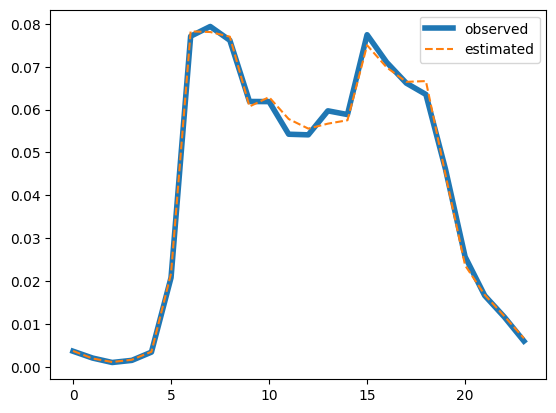

In [397]:
def get_euclidean_avg(key, input_dict, neighbors):
    neighbor_data = np.array([input_dict[(neighbor, key[1])].values for neighbor in neighbors])
    return np.mean(neighbor_data, axis=0).flatten()

def evaluate_dist_threshold_euclidean(key, input_dict, euclidean_dists, dist_threshold):
    neighbors = get_neighbors(key, input_dict, euclidean_dists, dist_threshold)
    if len(neighbors) == 0: # if no neighbors, return high number
        return np.inf
    observed_data = normalized_dict.get(key).values # observed
    est = get_euclidean_avg(key, normalized_dict, neighbors) # estimated
    return np.mean(np.power(observed_data.flatten() - est, 2)) # return squared Euclidean distance

def optimize_dist_threshold_euclidean(key, input_dict, euclidean_dists, max_threshold = 2.0):
    def obj(dist_threshold):
        return evaluate_dist_threshold_euclidean(key=key, 
                                                 input_dict=input_dict, 
                                                 euclidean_dists=euclidean_dists, 
                                                 dist_threshold=dist_threshold)
    
    best_eta = fmin(fn=obj, verbose = True, space=hp.uniform('eta', 0.00001, max_threshold), algo=tpe.suggest, max_evals=50)
    return best_eta['eta']

key = ((24, 2), (36, 2017))
dist_threshold = optimize_dist_threshold_euclidean(key, normalized_dict, euclidean_dists)
print(f'Distance Threshold: {dist_threshold}')
neighbors = get_neighbors(key, normalized_dict, euclidean_dists, dist_threshold)
if normalized_dict.get(key) is not None:
    neighbors.append(key[0])
print(f'Number of neighbors (including self): {len(neighbors)}')
plt.figure()
plt.plot(range(24), normalized_dict.get(key).values, label='observed', linewidth=4)
est = get_euclidean_avg(key, normalized_dict, neighbors)
plt.plot(range(24), est, label='estimated', linestyle='--')
plt.legend()
plt.show()

#### 3. (no normalization, Euclidean)

In [373]:
key = ((24, 2), (36, 2017))
euclidean_dists_raw = get_euclidean_dists(key, data_dict)

100%|██████████| 25900/25900 [00:04<00:00, 6192.33it/s]


100%|██████████| 50/50 [00:01<00:00, 32.98trial/s, best loss: 0.00021116582571683204]
Distance Threshold: 33620088535.91187
Number of neighbors (including self): 42


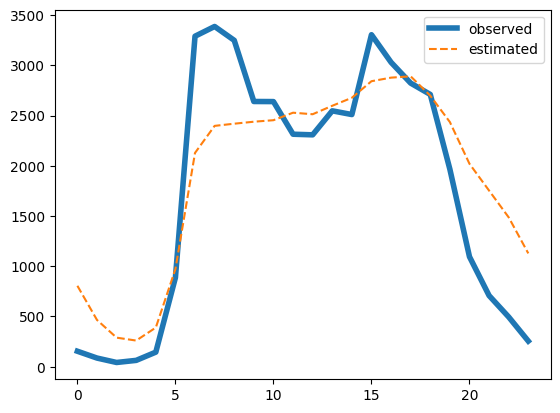

In [399]:
key = ((24, 2), (36, 2017))
dist_threshold = optimize_dist_threshold_euclidean(key, data_dict, euclidean_dists_raw, max_threshold=10e10)
print(f'Distance Threshold: {dist_threshold}')
neighbors = get_neighbors(key, data_dict, euclidean_dists_raw, dist_threshold)
if data_dict.get(key) is not None:
    neighbors.append(key[0])
print(f'Number of neighbors (including self): {len(neighbors)}')
plt.figure()
plt.plot(range(24), data_dict.get(key).values, label='observed', linewidth=4)
est = get_euclidean_avg(key, data_dict, neighbors)
plt.plot(range(24), est, label='estimated', linestyle='--')
plt.legend()
plt.show()

<Axes: xlabel='Hour'>

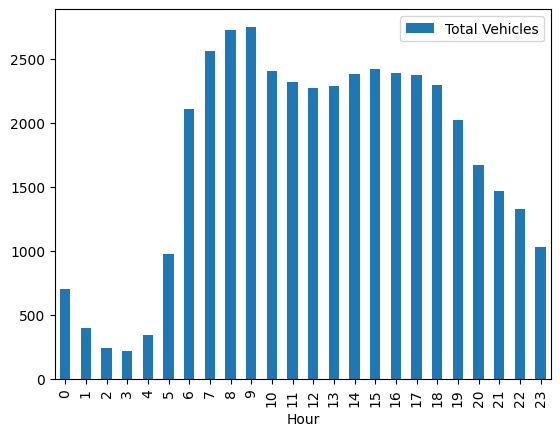

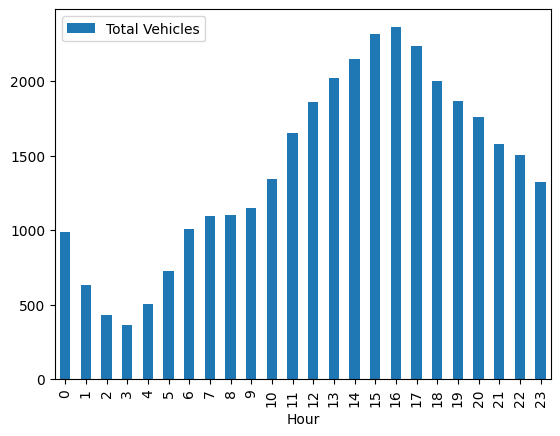

In [123]:
inbound = mta_data_queens_midtown_tunnel[mta_data_queens_midtown_tunnel['Direction'] == 'I']
outbound = mta_data_queens_midtown_tunnel[mta_data_queens_midtown_tunnel['Direction'] == 'O']

total_vehicles_in = inbound['# Vehicles - E-ZPass'] + inbound['# Vehicles - VToll']
inbound['Total Vehicles'] = total_vehicles_in

total_vehicles_out = outbound['# Vehicles - E-ZPass'] + outbound['# Vehicles - VToll']
outbound['Total Vehicles'] = total_vehicles_out

cols = ['Hour', 'Total Vehicles']

inbound = inbound[cols]
inbound.groupby('Hour').mean().plot(kind='bar')

outbound = outbound[cols]
outbound.groupby('Hour').mean().plot(kind='bar')

<Axes: xlabel='Hour'>

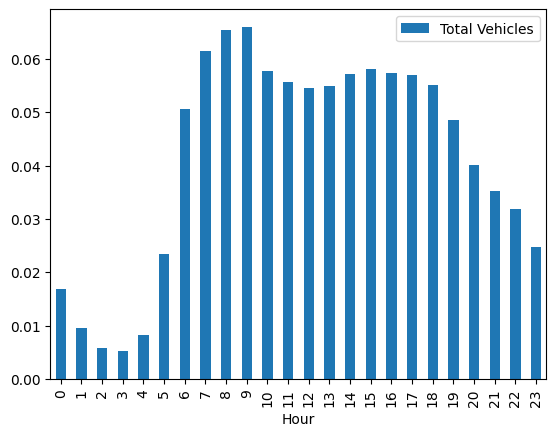

In [124]:
# We don't want to lose the time series information
# Essentially, we are doing functional matrix completion as opposed to distributional.
# There should not really be much of a difference if we also impute the total number of cars in a matrix cell.

# Let's analyze the wasserstein barycenter between two discrete distributions

inbound_mean = inbound.groupby('Hour').mean()

inbound_mean_scaled = inbound_mean / inbound_mean.sum()
inbound_mean_scaled.plot(kind='bar')

<Axes: xlabel='Hour'>

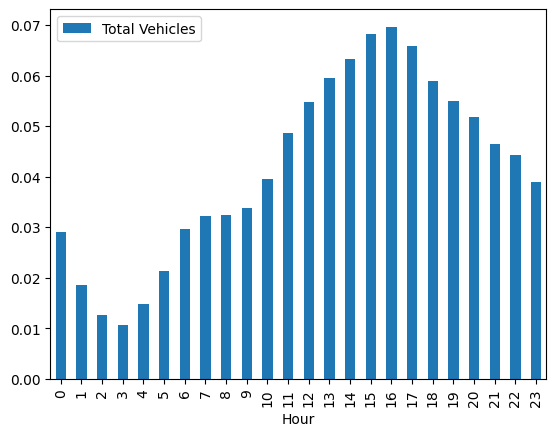

In [125]:
outbound_mean = outbound.groupby('Hour').mean()

outbound_mean_scaled = outbound_mean / outbound_mean.sum()
outbound_mean_scaled.plot(kind='bar')

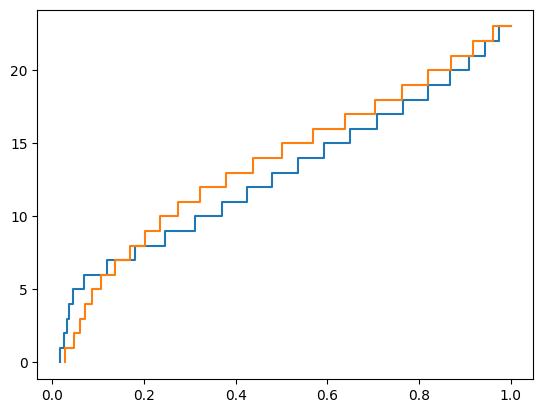

In [126]:
inbound_mean_scaled_cumsum = inbound_mean_scaled.cumsum()
outbound_mean_scaled_cumsum = outbound_mean_scaled.cumsum()

plt.step(inbound_mean_scaled_cumsum,inbound_mean_scaled_cumsum.index)
plt.step(outbound_mean_scaled_cumsum,outbound_mean_scaled_cumsum.index)

In [128]:
values = inbound_mean_scaled.index.to_numpy()
cdf = inbound_mean_scaled_cumsum.values.flatten()

In [129]:
from scipy.integrate import quad
from functools import partial
from numpy import quantile

import warnings
warnings.filterwarnings("ignore")

def wasserstein2(inv_cdf1, inv_cdf2):
    """
    Compute the squared 2-Wasserstein metric.
    """
    # Combine the inner part of the integral into one function
    # Estimate integral via quadrature
    y, _ = quad(lambda x : np.power((inv_cdf1(x) - inv_cdf2(x)), 2), 0, 1)
    return y

In [130]:
ppf1 = partial(discrete_quantile, inbound_mean_scaled_cumsum.index.to_numpy(), inbound_mean_scaled_cumsum.values.flatten())
ppf2 = partial(discrete_quantile, outbound_mean_scaled_cumsum.index.to_numpy(), outbound_mean_scaled_cumsum.values.flatten())

wasserstein2(ppf1, ppf2)

1.9632668101896897